# ***Libraries & Tools***

In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn as sk
import re
import random
import math
from itertools import chain, groupby, product
from enum import Enum
from typing import Callable, DefaultDict, Dict, List, Optional, Set, Tuple
from typing import Any
import string
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from gensim.models import KeyedVectors
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [48]:
nltk.download('averaged_perceptron_tagger', download_dir='/home/georgematlis/AUTh/NLP/Keyword-Extraction/Downloads')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/georgematlis/AUTh/NLP/Keyword-
[nltk_data]     Extraction/Downloads...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
nltk.data.path.append("/home/georgematlis/AUTh/NLP/Keyword-Extraction/Downloads")

# ***Data & Data Pre-Processing***

In [3]:
rt_movies = pd.read_csv("Massive Rotten Tomatoes Movies and Reviews/rotten_tomatoes_movies.csv")
rt_reviews = pd.read_csv("Massive Rotten Tomatoes Movies and Reviews/rotten_tomatoes_movie_reviews.csv")

In [4]:
SEED = 42

In [4]:
rt_movies.head(5)

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN
3,the_sore_losers_1997,Sore Losers,60.0,NaN,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy,NaN,NaN,NaN
4,dinosaur_island_2002,Dinosaur Island,70.0,NaN,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy,NaN,NaN,NaN


In [5]:
rt_reviews.head(5)

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [6]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444963 entries, 0 to 1444962
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1444963 non-null  object
 1   reviewId        1444963 non-null  int64 
 2   creationDate    1444963 non-null  object
 3   criticName      1444963 non-null  object
 4   isTopCritic     1444963 non-null  bool  
 5   originalScore   1009745 non-null  object
 6   reviewState     1444963 non-null  object
 7   publicatioName  1444963 non-null  object
 8   reviewText      1375738 non-null  object
 9   scoreSentiment  1444963 non-null  object
 10  reviewUrl       1234038 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 111.6+ MB


In [12]:
rt_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      143258 non-null  object
 1   title   142891 non-null  object
 2   genre   132175 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


In [14]:
rt_reviews.isnull().sum()

id                0
reviewId          0
isTopCritic       0
reviewState       0
reviewText        0
scoreSentiment    0
dtype: int64

In [11]:
rt_movies.isnull().sum()

id           0
title      367
genre    11083
dtype: int64

In [5]:
rt_reviews.drop(columns=['reviewUrl', 'originalScore', 'publicatioName', 'criticName', 'creationDate'], inplace=True)
rt_movies.drop(columns=['soundMix', 'distributor', 'boxOffice', 'writer', 'director', 'originalLanguage', 'runtimeMinutes', 'releaseDateStreaming', 'releaseDateTheaters', 'ratingContents', 
                        'rating', 'tomatoMeter', 'audienceScore'], inplace=True)

In [6]:
rt_reviews.dropna(inplace=True)

In [7]:
rt_reviews['reviewState'].value_counts().sum

<bound method Series.sum of reviewState
fresh     922510
rotten    453228
Name: count, dtype: int64>

In [8]:
rt_reviews['isTopCritic'].value_counts().sum

<bound method Series.sum of isTopCritic
False    949438
True     426300
Name: count, dtype: int64>

In [9]:
rt_reviews['scoreSentiment'].value_counts().sum

<bound method Series.sum of scoreSentiment
POSITIVE    922510
NEGATIVE    453228
Name: count, dtype: int64>

In [7]:
rt_reviews['scoreSentiment'] = rt_reviews['scoreSentiment'].map({'POSITIVE': 0, 'NEGATIVE': 1})

In [8]:
rt_reviews['reviewState'] = rt_reviews['reviewState'].map({'fresh': 0, 'rotten': 1})

In [9]:
rt_reviews['reviewText'].str.contains('<br />', na=False).any()

False

In [120]:
# Remove "<br />" characters from the reviews
rt_reviews['reviewText'] = rt_reviews['reviewText'].str.replace('<br />', '', regex=False)

In [10]:
num_false = rt_reviews['reviewText'].apply(lambda x: not x[0].isupper()).sum()

print(f"There are {num_false} rows without a starting capital letter.")

There are 97360 rows without a starting capital letter.


In [122]:
def capitalize_if_needed(review):
    if not review[0].isupper():
        return review.capitalize()
    return review

rt_reviews['reviewText'] = rt_reviews['reviewText'].apply(capitalize_if_needed)

In [10]:
num_no_period = rt_reviews['reviewText'].apply(lambda x: not x.endswith('.')).sum()

print(f"There are {num_no_period} reviews that don't end with a period.")

There are 0 reviews that don't end with a period.


In [9]:
def ensure_ends_with_period(review):
    if not review.endswith('.'):
        return review + '.'
    return review

rt_reviews['reviewText'] = rt_reviews['reviewText'].apply(ensure_ends_with_period)

In [32]:
filtered_reviews = rt_reviews[
    (rt_reviews['scoreSentiment'] == 0) &
    (rt_reviews['isTopCritic'] == True) &
    (rt_reviews['reviewState'] == 0)
]

# Count the number of reviews for each movie id
review_counts = filtered_reviews.groupby('id').size().reset_index(name='review_count')

# Sort the counts in descending order and get the top 10
top_10_movies = review_counts.sort_values(by='review_count', ascending=False).head(10)

print(top_10_movies)

                              id  review_count
20712              parasite_2019           166
6018   blue_is_the_warmest_color           116
3939           american_splendor           110
1917       1193230-state_of_play           106
7051         catch_me_if_you_can           102
2326               28_days_later            98
17986               meeks_cutoff            98
31412                wadjda_2013            98
5795          black_panther_2018            97
3041         a_star_is_born_2018            95


In [33]:
movie_ids = [
    'parasite_2019',
    #'avenegers_endgame',
    #'black_panther_2018',
    #'once_upon_a_time_in_hollywood'
    'blue_is_the_warmest_color',
    'american_splendor',
    'catch_me_if_you_can'
]

sampled_data = []

for mv_id in movie_ids:
    sampled_data.append(filtered_reviews[rt_reviews['id'] == mv_id])

/tmp/ipykernel_17259/2455867121.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sampled_data.append(filtered_reviews[rt_reviews['id'] == mv_id])
/tmp/ipykernel_17259/2455867121.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sampled_data.append(filtered_reviews[rt_reviews['id'] == mv_id])
/tmp/ipykernel_17259/2455867121.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sampled_data.append(filtered_reviews[rt_reviews['id'] == mv_id])
/tmp/ipykernel_17259/2455867121.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sampled_data.append(filtered_reviews[rt_reviews['id'] == mv_id])


In [34]:
movie_id = 'catch_me_if_you_can'

filtered_reviews = filtered_reviews[rt_reviews['id'] == movie_id]

# Print the number of filtered reviews
num_reviews = len(filtered_reviews)
print(f"Number of reviews for movie ID {movie_id} that satisfy the conditions: {num_reviews}")

Number of reviews for movie ID catch_me_if_you_can that satisfy the conditions: 102


/tmp/ipykernel_17259/1326672633.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_reviews = filtered_reviews[rt_reviews['id'] == movie_id]


In [35]:
# Create a paragraph for the POSITIVE reviews of a given movie
positive_reviews = filtered_reviews['reviewText']
positive_paragraph = ' '.join(positive_reviews)
print("Concatenated Positive Reviews:\n", positive_paragraph)

Concatenated Positive Reviews:
 Excellent account of FBI's youngest Most Wanted. This is the director's most likeable film in ages, even if it's insubstantial, overlong and, frankly, a touch redundant. Arguably the most gifted young actor of his generation, Leonardo DiCaprio has definitely been a victim of his own success. Leo bashing was all the rage there for a while after his monster smash Titanic. Hanratty isn't a strictly factual character - he's called O'Reilly in the book, not his real name either - but the performance Hanks gives makes you wish he were. Abagnale isn't strictly factual either, but DiCaprio makes him an attractive counterfeit. This is a delectable film indeed. A fitting dessert to Spielberg's preceeding entree and main course of A.I. and Minority Report, and one hell of a ride. DiCaprio has the breeze and aplomb to keep it all bouncing along. Breezily enjoyable but thin. Spielberg rediscovers his sense of fun with this funny, frivolous con caper. A delicious cat-

In [20]:
def generate_sample(df, num_samples, used_indices):
    # Separate positive and negative reviews
    positive_reviews = df[(df['scoreSentiment'] == 0) & (df['isTopCritic'] == True) & (df['reviewState'] == 0)]
    negative_reviews = df[(df['scoreSentiment'] == 1) & (df['isTopCritic'] == True) & (df['reviewState'] == 1)]
    
    # Exclude used indices
    available_positive_reviews = positive_reviews[~positive_reviews.index.isin(used_indices)]
    available_negative_reviews = negative_reviews[~negative_reviews.index.isin(used_indices)]
    
    # Sample reviews without replacement
    sampled_positive = available_positive_reviews.sample(n=num_samples, replace=False, random_state=SEED)
    sampled_negative = available_negative_reviews.sample(n=num_samples, replace=False, random_state=SEED)
    
    # Update used indices
    used_indices.update(sampled_positive.index)
    used_indices.update(sampled_negative.index)
    
    # Concatenate the two DataFrames
    sampled_df = pd.concat([sampled_positive, sampled_negative]).reset_index(drop=True)
    
    return sampled_df, used_indices

In [34]:
sample_sizes = [
    128, 256, 512, 1024
]
sampled_data = []
used_indices = set()


for sample_size in sample_sizes:
    sampled_df, used_indices = generate_sample(rt_reviews, sample_size, used_indices)
    sampled_data.append(sampled_df)

Create positive and negative paragraphs from the samples.

In [23]:
positive_paragraphs = []
negative_paragraphs = []

for df in sampled_data:
    positive_reviews = df[(df['scoreSentiment'] == 0) & (df['isTopCritic'] == True) & (df['reviewState'] == 0)]['reviewText']
    positive_paragraph = ' '.join(positive_reviews)
    positive_paragraphs.append(positive_paragraph)

    negative_reviews = df[(df['scoreSentiment'] == 1) & (df['isTopCritic'] == True) & (df['reviewState'] == 1)]['reviewText']
    negative_paragraph = ' '.join(negative_reviews)
    negative_paragraphs.append(negative_paragraph)

In [15]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

## Pre-processing for one sample

In [10]:
# Create a paragraph for the POSITIVE reviews
positive_reviews = sampled_data[-1][(sampled_data[-1]['scoreSentiment'] == 0) & (sampled_data[-1]['isTopCritic'] == True) & (sampled_data[-1]['reviewState'] == 0)]['reviewText']
positive_paragraph = ' '.join(positive_reviews)
print("Concatenated Positive Reviews:\n", positive_paragraph)

Concatenated Positive Reviews:
 There is a story (possibly apocryphal) about an exchange between bruce willis and terry gilliam at the start of twelve monkeys. gilliam (allegedly) produced a long list (think about the aircraft one from the fifth element) and handed it to butch bruce. it was entitled "things bruce willis does when he acts". it ended with a simple message saying: "please don't do any of the above in my movie".there is a fact about this movie (definitely true). gilliam didn't have a hand in the writing.i would contend that these two factors played a huge role in creating the extraordinary (if not commercial) success that is the twelve monkeys.visually, the twelve monkeys is all that we have rightly come to expect from a gilliam film. it is also full of gilliamesque surrealism and general (but magnificent) strangeness. gilliam delights in wrong-footing his audience. although the ending of the twelve monkeys will surprise no one who has sat through the first real, gilliam b

In [11]:
# Create a paragraph for the NEGATIVE reviews
negative_reviews = sampled_data[-1][(sampled_data[-1]['scoreSentiment'] == 1) & (sampled_data[-1]['isTopCritic'] == True) & (sampled_data[-1]['reviewState'] == 1)]['reviewText']
negative_paragraph = ' '.join(negative_reviews)
print("Concatenated Negative Reviews:\n", negative_paragraph)

Concatenated Negative Reviews:
 I recently viewed manufactured landscapes at the seattle international film festival. i was drawn to the movie as a photographer because i'm both familiar and a fan of burtynsky's work. while i believe the movie does a good job getting it's message across, i couldn't help but feel that it was made as a complete afterthought to the photographs and subsequent popular book by burtynsky. obviously one reason for this is the extensive use of still photographs featuring zooms and pans across them. while this is a good effect when used economically, i felt like 75% of the movie was just stills from burtynsky's book (which i already own). that's probably an exaggeration, but that's how i felt. if you own the book or are familiar with his work you might be better off skipping this one. I figured that any horror film with orson welles in it would be weird. necromancy sure was but it was a little too weird for it's own good. the film does indeed have a creepy feel 

In [37]:
def classify_sentence(sentence, sentiment_threshold):
    words = re.findall(r'\b\w+\b', sentence.lower())
    
    positive_words = []
    negative_words = []
    
    # Classify each word
    for word in words:
        # Get the sentiment scores for the word
        scores = analyzer.polarity_scores(word)
        
        # Determine if the word is positive or negative
        if scores['compound'] >= sentiment_threshold:
            positive_words.append(word)
        elif scores['compound'] <= -sentiment_threshold:
            negative_words.append(word)
    
    # Count frequencies of positive and negative words
    positive_word_freq = dict(Counter(positive_words))
    negative_word_freq = dict(Counter(negative_words))
    
    return positive_word_freq, negative_word_freq

In [39]:
# Distinguish positive from negative words for a POSITIVE paragraph
positive_words, negative_words = classify_sentence(positive_paragraphs[-1], 0.35)
print("Positive Words:", positive_words)
print("Negative Words:", negative_words)

Positive Words: {'kind': 21, 'inspired': 4, 'love': 35, 'daring': 4, 'enjoyably': 1, 'pleasure': 7, 'empathetic': 2, 'happy': 4, 'interesting': 4, 'stunning': 3, 'accomplished': 6, 'like': 70, 'impressive': 5, 'talent': 3, 'best': 36, 'sweet': 9, 'beloved': 2, 'party': 2, 'delightfully': 1, 'hilarious': 5, 'comedy': 28, 'successful': 2, 'importance': 1, 'gentle': 6, 'powerful': 11, 'rapturous': 1, 'pleasant': 4, 'heart': 19, 'definitely': 3, 'wish': 5, 'playful': 1, 'idealistic': 1, 'laughter': 1, 'smart': 12, 'entertaining': 5, 'lovely': 10, 'beautifully': 10, 'joy': 4, 'welcome': 8, 'better': 16, 'won': 7, 'good': 43, 'wonderful': 5, 'fun': 25, 'amazing': 2, 'laughing': 2, 'benefit': 2, 'convincing': 3, 'successfully': 1, 'charm': 5, 'hero': 6, 'honest': 6, 'brilliant': 10, 'pleasing': 4, 'cheers': 1, 'honestly': 3, 'romance': 6, 'justice': 2, 'thrill': 3, 'ethical': 1, 'brilliantly': 7, 'pleasures': 4, 'satisfying': 11, 'cleverly': 1, 'trust': 1, 'excitement': 1, 'bold': 2, 'strong'

In [41]:
# Distinguish positive from negative words for a NEGATIVE paragraph
positive_words, negative_words = classify_sentence(negative_paragraphs[-1], 0.6)
print("Positive Words:", positive_words)
print("Negative Words:", negative_words)

Positive Words: {'best': 18, 'heart': 5, 'great': 6, 'love': 15, 'greatest': 1, 'awesome': 3, 'gorgeous': 1, 'hearts': 3, 'perfectly': 2, 'glee': 1}
Negative Words: {'disaster': 2, 'devil': 2, 'violence': 7, 'slavery': 1, 'killing': 1, 'destructive': 1, 'doomed': 2, 'worst': 7, 'racist': 2, 'tragedy': 1, 'fatality': 1, 'murder': 1, 'dead': 10, 'evil': 4, 'apocalyptic': 1, 'terrorist': 1, 'crisis': 3, 'killer': 1, 'brutally': 1, 'dismal': 1, 'catastrophe': 1, 'fatally': 2, 'villains': 1, 'brutality': 1, 'suicide': 1}


In [169]:
# Concatenate positive and negative word frequencies
combined_word_freq = {**positive_words, **negative_words}

## Word Cloud

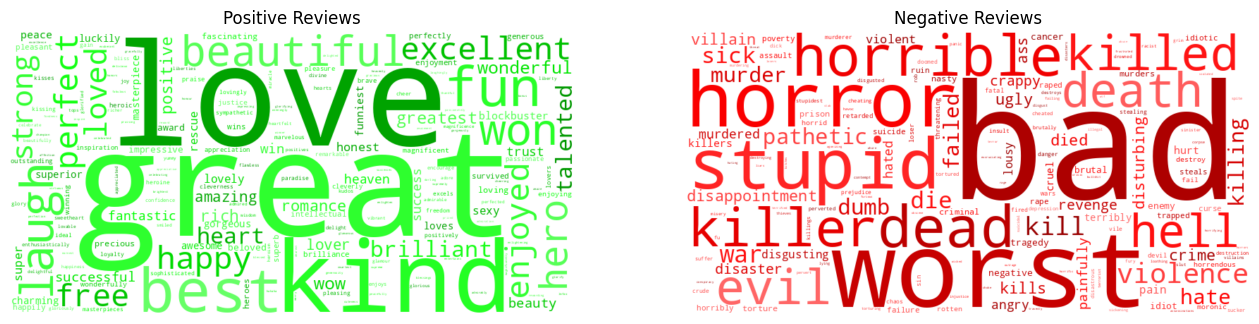

In [167]:
# Custom color functions
def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(120, 100%%, %d%%)" % random.randint(30, 70)

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 70)

# Create a word cloud for positive reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=green_color_func).generate_from_frequencies(positive_words)

# Create a word cloud for negative reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=red_color_func).generate_from_frequencies(negative_words)

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

# Negative reviews word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')

plt.show()

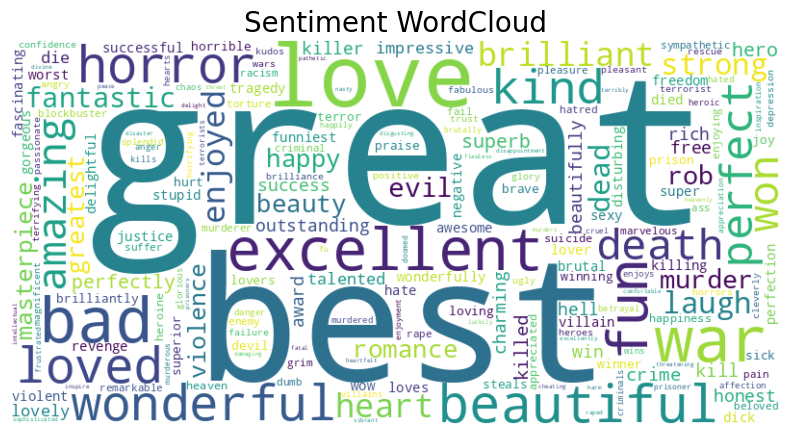

In [170]:
sentiment_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_word_freq)


plt.figure(figsize=(10, 5))
plt.imshow(sentiment_wordcloud, interpolation='bilinear')
plt.title("Sentiment WordCloud", fontsize=20)
plt.axis('off')
plt.show()

# ***RAKE (Rapid Automatic Keyword Extraction)***

## RAKE Implementation from https://csurfer.github.io/rake-nltk/_build/html/_modules/rake_nltk/rake.html


In [16]:
# Readability type definitions.
Word = str
Sentence = str
Phrase = Tuple[str, ...]

In [17]:
class Metric(Enum):
    """Different metrics that can be used for ranking."""

    DEGREE_TO_FREQUENCY_RATIO = 0  # Uses d(w)/f(w) as the metric
    WORD_DEGREE = 1  # Uses d(w) alone as the metric
    WORD_FREQUENCY = 2  # Uses f(w) alone as the metric

In [18]:
class Rake:
    """Rapid Automatic Keyword Extraction Algorithm."""

    def __init__(
        self,
        stopwords: Optional[Set[str]] = None,
        punctuations: Optional[Set[str]] = None,
        language: str = 'english',
        ranking_metric: Metric = Metric.DEGREE_TO_FREQUENCY_RATIO,
        max_length: int = 100000,
        min_length: int = 1,
        include_repeated_phrases: bool = True,
        sentence_tokenizer: Optional[Callable[[str], List[str]]] = None,
        word_tokenizer: Optional[Callable[[str], List[str]]] = None,
        similarity_model: Any = None,
        keyword_threshold: float = 0.7,
        word_threshold: float = 0.7,
        sentiment_threshold: float = 0.6,
        adjust_keyword_score: bool = False
    ):
        """Constructor.

        :param stopwords: Words to be ignored for keyword extraction.
        :param punctuations: Punctuations to be ignored for keyword extraction.
        :param language: Language to be used for stopwords.
        :param max_length: Maximum limit on the number of words in a phrase
                           (Inclusive. Defaults to 100000)
        :param min_length: Minimum limit on the number of words in a phrase
                           (Inclusive. Defaults to 1)
        :param include_repeated_phrases: If phrases repeat in phrase list consider
                            them as is without dropping any phrases for future
                            calculations. (Defaults to True) Ex: "Magic systems is
                            a company. Magic systems was founded by Raul".

                            If repeated phrases are allowed phrase list would be
                            [
                                (magic, systems), (company,), (magic, systems),
                                (founded,), (raul,)
                            ]

                            If they aren't allowed phrase list would be
                            [
                                (magic, systems), (company,),
                                (founded,), (raul,)
                            ]
        :param sentence_tokenizer: Tokenizer used to tokenize the text string into sentences.
        :param word_tokenizer: Tokenizer used to tokenize the sentence string into words.
        """
        # The similarity model. Could be any model with pre-trained embeddings. e.g Word2Vec, Spacy
        self.similarity_model: Any = similarity_model
        
        # The similarity threshold between two individual keywords
        self.keyword_threshold: float = keyword_threshold

        # The similarity threshold between two individual words
        self.word_threshold: float = word_threshold

        # The sentiment threshold for an individual word
        self.sentiment_threshold: float = sentiment_threshold
        
        # Divide the score by the number of words in a keyword
        self.adjust_keyword_score: bool = adjust_keyword_score

        # A list to contain all similar words 
        self.similar_words = []


        # By default use degree to frequency ratio as the metric.
        if isinstance(ranking_metric, Metric):
            self.metric = ranking_metric
        else:
            self.metric = Metric.DEGREE_TO_FREQUENCY_RATIO

        # If stopwords not provided we use language stopwords by default.
        self.stopwords: Set[str]
        if stopwords:
            self.stopwords = stopwords
        else:
            self.stopwords = set(nltk.corpus.stopwords.words(language))

        # If punctuations are not provided we ignore all punctuation symbols.
        self.punctuations: Set[str]
        if punctuations:
            self.punctuations = punctuations
        else:
            self.punctuations = set(string.punctuation)

        # All things which act as sentence breaks during keyword extraction.
        self.to_ignore: Set[str] = set(chain(self.stopwords, self.punctuations))

        # Assign min or max length to the attributes
        self.min_length: int = min_length
        self.max_length: int = max_length

        # Whether we should include repeated phreases in the computation or not.
        self.include_repeated_phrases: bool = include_repeated_phrases

        # Tokenizers.
        self.sentence_tokenizer: Callable[[str], List[str]]
        if sentence_tokenizer:
            self.sentence_tokenizer = sentence_tokenizer
        else:
            self.sentence_tokenizer = nltk.tokenize.sent_tokenize

        self.word_tokenizer: Callable[[str], List[str]]
        if word_tokenizer:
            self.word_tokenizer = word_tokenizer
        else:
            self.word_tokenizer = nltk.tokenize.wordpunct_tokenize

        # Stuff to be extracted from the provided text.
        self.frequency_dist: Dict[Word, int]
        self.degree: Dict[Word, int]
        self.rank_list: List[Tuple[float, Sentence]]
        self.ranked_phrases: List[Sentence]

    def extract_keywords_from_text(self, text: str):
        """Method to extract keywords from the text provided.

        :param text: Text to extract keywords from, provided as a string.
        """
        sentences: List[Sentence] = self._tokenize_text_to_sentences(text)
        self.extract_keywords_from_sentences(sentences)


    def extract_keywords_from_sentences(self, sentences: List[Sentence]):
        """Method to extract keywords from the list of sentences provided.

        :param sentences: Text to extraxt keywords from, provided as a list
                          of strings, where each string is a sentence.
        """
        phrase_list: List[Phrase] = self._generate_phrases(sentences)
        #print(phrase_list)
        self._build_frequency_dist(phrase_list)
        self._build_word_co_occurance_graph(phrase_list)
        self._build_ranklist(phrase_list)


    def get_ranked_phrases(self) -> List[Sentence]:
        """Method to fetch ranked keyword strings.

        :return: List of strings where each string represents an extracted
                 keyword string.
        """
        return self.ranked_phrases


    def get_ranked_phrases_with_scores(self) -> List[Tuple[float, Sentence]]:
        """Method to fetch ranked keyword strings along with their scores.

        :return: List of tuples where each tuple is formed of an extracted
                 keyword string and its score. Ex: (5.68, 'Four Scoures')
        """
        return self.rank_list


    def get_word_frequency_distribution(self) -> Dict[Word, int]:
        """Method to fetch the word frequency distribution in the given text.

        :return: Dictionary (defaultdict) of the format `word -> frequency`.
        """
        return self.frequency_dist


    def get_word_degrees(self) -> Dict[Word, int]:
        """Method to fetch the degree of words in the given text. Degree can be
        defined as sum of co-occurances of the word with other words in the
        given text.

        :return: Dictionary (defaultdict) of the format `word -> degree`.
        """
        return self.degree


    def _tokenize_text_to_sentences(self, text: str) -> List[Sentence]:
        """Tokenizes the given text string into sentences using the configured
        sentence tokenizer. Configuration uses `nltk.tokenize.sent_tokenize`
        by default.

        :param text: String text to tokenize into sentences.
        :return: List of sentences as per the tokenizer used.
        """
        return self.sentence_tokenizer(text)

    def _tokenize_sentence_to_words(self, sentence: Sentence) -> List[Word]:
        """Tokenizes the given sentence string into words using the configured
        word tokenizer. Configuration uses `nltk.tokenize.wordpunct_tokenize`
        by default.

        :param sentence: String sentence to tokenize into words.
        :return: List of words as per the tokenizer used.
        """
        return self.word_tokenizer(sentence)

    def _build_frequency_dist(self, phrase_list: List[Phrase]) -> None:
        """Builds frequency distribution of the words in the given body of text.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        self.frequency_dist = Counter(chain.from_iterable(phrase_list))

    def _build_word_co_occurance_graph(self, phrase_list: List[Phrase]) -> None:
        """Builds the co-occurance graph of words in the given body of text to
        compute degree of each word.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        co_occurance_graph: DefaultDict[Word, DefaultDict[Word, int]] = defaultdict(lambda: defaultdict(lambda: 0))
        for phrase in phrase_list:
            # For each phrase in the phrase list, count co-occurances of the
            # word with other words in the phrase.
            #
            # Note: Keep the co-occurances graph as is, to help facilitate its
            # use in other creative ways if required later.
            for (word, coword) in product(phrase, phrase):
                co_occurance_graph[word][coword] += 1

        # Print the co-occurance_graph
        """
        for word, co_words in co_occurance_graph.items():
            print(f"{word}:")
            for co_word, count in co_words.items():
                print(f"  {co_word}: {count}")
            print("=" * 30)
        """
        self.degree = defaultdict(lambda: 0)
        for key in co_occurance_graph:
            self.degree[key] = sum(co_occurance_graph[key].values())


    # ==== My additions to the original algorithm ====

    def _word2vec_calculate_word_similarity(self, metric):
      target_vectors = []
      filtered_words = []

      if metric == 'degree':
        words = self._classify_words_by_their_sentiment_and_class(self.degree.keys())
        #words = self._classify_words_by_their_class(self.degree.keys())
        for word in words:
          if word in self.similarity_model:
            target_vectors.append(self.similarity_model[word])
            filtered_words.append(word)
      else:
        words = self._classify_words_by_their_sentiment_and_class(self.frequency_dist.keys())
        #words = self._classify_words_by_their_class(self.frequency_dist.keys())
        for word in words:
          if word in self.similarity_model:
            target_vectors.append(self.similarity_model[word])
            filtered_words.append(word)

      if not target_vectors:
          return None

      similarity_matrix = cosine_similarity(target_vectors, target_vectors)
      return similarity_matrix, filtered_words
    
    def _classify_words_by_their_sentiment(self, words):
        words_with_sentiment = []
        
        # Clean each word and classify its sentiment
        for word in words:
            # Remove special characters and convert to lowercase
            #clean_word = re.sub(r'\W+', '', word.lower())
            
            # Get the sentiment scores for the clean word
            scores = analyzer.polarity_scores(word)
            
            # Determine if the word is positive or negative
            if scores['compound'] >= self.sentiment_threshold:
                words_with_sentiment.append(word)
            elif scores['compound'] <= -self.sentiment_threshold:
                words_with_sentiment.append(word)
        
        return words_with_sentiment

    def _classify_words_by_their_sentiment_and_class(self, words):
        words_with_sentiment = []
        
        # Clean each word and classify its sentiment
        for word in words:
            # Remove special characters and convert to lowercase
            #clean_word = re.sub(r'\W+', '', word.lower())
            
            # Get the sentiment scores for the clean word
            scores = analyzer.polarity_scores(word)

            pos = pos_tag([word])[0][1]
            
            # Determine if the word is positive or negative
            if scores['compound'] >= self.sentiment_threshold or pos in ['JJ', 'JJR', 'JJS']:
                words_with_sentiment.append(word)
            elif scores['compound'] <= -self.sentiment_threshold or pos in ['JJ', 'JJR', 'JJS']:
                words_with_sentiment.append(word)
        
        return words_with_sentiment
    
    def _classify_words_by_their_class(self, words):
        adjectives = []
        
        for word in words:
            if re.match(r'^[A-Za-z]+$', word) is not None:
                pos = pos_tag([word])[0][1]
                if pos in ['JJ', 'JJR', 'JJS']:
                    adjectives.append(word)
        
        return adjectives

    def _merge_word_vector_scores(self, similarity_matrix, metric, filtered_words):
        word_scores = metric

        for i in range(len(filtered_words) - 1):
            for j in range(i + 1, len(filtered_words), 1):
                if similarity_matrix[i][j - (1 + i)] >= self.word_threshold:
                    # Mutual score increase
                    word_scores[filtered_words[i]] += metric[filtered_words[j]]
                    word_scores[filtered_words[j]] += metric[filtered_words[i]]
       
        """
        for i in range(len(filtered_words)-1):
            for j in range(i+1, len(filtered_words), 1):
                if similarity_matrix[i][j-(1+i)] >= self.keyword_threshold:
                    if metric[filtered_words[i]] > metric[filtered_words[j]]:
                        word_scores[filtered_words[i]] += metric[filtered_words[j]]
                    elif metric[filtered_words[j]] > metric[filtered_words[i]]:
                        word_scores[filtered_words[j]] += metric[filtered_words[i]]
        """
        return word_scores
    
    def _find_similar_words(self, similarity_matrix, filtered_words):
        for i in range(len(filtered_words) - 1):
            for j in range(i + 1, len(filtered_words), 1):
                if similarity_matrix[i][j - (1 + i)] >= self.word_threshold:
                    self.similar_words.append((filtered_words[i], filtered_words[j]))

    # Function to get the embedding of a keyword using Word2Vec
    def get_keyword_embedding(self, keyword, default_vector=None):
        words = keyword.split()
        word_embeddings = []

        for word in words:
            if word in self.similarity_model:
                word_embeddings.append(self.similarity_model[word])
            elif default_vector is not None:
                word_embeddings.append(default_vector)
        
        if not word_embeddings:
            return None
        
        return np.mean(word_embeddings, axis=0)

    # Function to update ranked_keywords based on similar_words
    def update_ranked_keywords(self, default_vector=None):
        # Create a dictionary for quick access to keyword scores
        keyword_dict = {kw: score for score, kw in self.rank_list}
        examined_words = []
        examined_keywords = set()
        
        # Process each pair in similar_words
        for word1, word2 in self.similar_words:
            # Find all keywords containing word1 and word2
            word1_keywords = list(set([kw for _, kw in self.rank_list if word1 in kw.split()]))
            word2_keywords = list(set([kw for _, kw in self.rank_list if word2 in kw.split()]))
            
            if not word1 in examined_words:
                examined_words.append(word1)

                # Calculate similarity within word1's keywords
                for i in range(len(word1_keywords) - 1):
                    emb1 = self.get_keyword_embedding(word1_keywords[i], default_vector)
                    if emb1 is None:
                        continue

                    for j in range(i + 1, len(word1_keywords)):
                        emb2 = self.get_keyword_embedding(word1_keywords[j], default_vector)
                        if emb2 is None:
                            continue
                        
                        keyword_pair = (word1_keywords[i], word1_keywords[j])

                        if not (keyword_pair in examined_keywords or (word1_keywords[j], word1_keywords[i]) in examined_keywords):
                            similarity = cosine_similarity([emb1], [emb2])[0][0]

                            if similarity >= self.keyword_threshold:
                                new_score = keyword_dict[word1_keywords[i]] + keyword_dict[word1_keywords[j]]
                                keyword_dict[word1_keywords[i]] = new_score
                                keyword_dict[word1_keywords[j]] = new_score
                            
                            examined_keywords.add(keyword_pair)

            if not word2 in examined_words:
                examined_words.append(word2)
                
                # Calculate similarity within word2's keywords
                for i in range(len(word2_keywords) - 1):
                    emb1 = self.get_keyword_embedding(word2_keywords[i], default_vector)
                    if emb1 is None:
                        continue

                    for j in range(i + 1, len(word2_keywords)):
                        emb2 = self.get_keyword_embedding(word2_keywords[j], default_vector)
                        if emb2 is None:
                            continue

                        keyword_pair = (word2_keywords[i], word2_keywords[j])

                        if not (keyword_pair in examined_keywords or (word2_keywords[j], word2_keywords[i]) in examined_keywords):
                            similarity = cosine_similarity([emb1], [emb2])[0][0]

                            if similarity >= self.keyword_threshold:
                                new_score = keyword_dict[word2_keywords[i]] + keyword_dict[word2_keywords[j]]
                                keyword_dict[word2_keywords[i]] = new_score
                                keyword_dict[word2_keywords[j]] = new_score
                            
                            examined_keywords.add(keyword_pair)

            # Now compare keywords between word1 and word2
            for kw1 in word1_keywords:
                emb1 = self.get_keyword_embedding(kw1, default_vector)
                if emb1 is None:
                    continue
                
                for kw2 in word2_keywords:
                    emb2 = self.get_keyword_embedding(kw2, default_vector)
                    if emb2 is None:
                        continue
                    
                    keyword_pair = (kw1, kw2)

                    if (not kw1 == kw2) and not (keyword_pair in examined_keywords or (kw2, kw1) in examined_keywords):
                        similarity = cosine_similarity([emb1], [emb2])[0][0]
                        
                        # If similarity exceeds threshold, update the scores
                        if similarity >= self.keyword_threshold:
                            new_score = keyword_dict[kw1] + keyword_dict[kw2]
                            keyword_dict[kw1] = new_score
                            keyword_dict[kw2] = new_score
                        
                        examined_keywords.add(keyword_pair)
        
        # Convert dictionary back to a list of tuples
        if self.adjust_keyword_score:
            updated_ranked_keywords = [(score / len(kw.split()), kw) for kw, score in keyword_dict.items()]
        else:
            updated_ranked_keywords = [(score, kw) for kw, score in keyword_dict.items()]
        return updated_ranked_keywords



    def _build_ranklist(self, phrase_list: List[Phrase]):
        """Method to rank each contender phrase using the formula

              phrase_score = sum of scores of words in the phrase.
              word_score = d(w) or f(w) or d(w)/f(w) where d is degree
                           and f is frequency.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """

        #print(f'Word Degree List: {self.degree}')
        #print(f'Word Frequency List: {self.frequency_dist}')

        if self.similarity_model:
            if self.metric == Metric.WORD_DEGREE:
                similarity_matrix, filtered_words = self._word2vec_calculate_word_similarity(metric='Degree')
                self._find_similar_words(similarity_matrix, filtered_words)
                #self.degree = self._merge_word_vector_scores(similarity_matrix, self.degree, filtered_words)
            elif self.metric == Metric.WORD_FREQUENCY:
                similarity_matrix, filtered_words = self._word2vec_calculate_word_similarity(metric='Frequency')
                self._find_similar_words(similarity_matrix, filtered_words)
                #self.frequency_dist = self._merge_word_vector_scores(similarity_matrix, self.frequency_dist, filtered_words)

        self.rank_list = []
        for phrase in phrase_list:
            rank = 0.0
            for word in phrase:
                if self.metric == Metric.DEGREE_TO_FREQUENCY_RATIO:
                    rank += 1.0 * self.degree[word] / self.frequency_dist[word]
                elif self.metric == Metric.WORD_DEGREE:
                    rank += 1.0 * self.degree[word]
                else:
                    rank += 1.0 * self.frequency_dist[word]

            if not self.adjust_keyword_score:
                self.rank_list.append((rank, ' '.join(phrase)))
            else:
                self.rank_list.append((rank / len(phrase), ' '.join(phrase)))
        self.rank_list.sort(reverse=True)
        
        if self.similarity_model:
            self.rank_list = self.update_ranked_keywords()
        
        self.ranked_phrases = [ph[1] for ph in self.rank_list]
        


    # ==========================================================================
    def _generate_phrases(self, sentences: List[Sentence]) -> List[Phrase]:
        """Method to generate contender phrases given the sentences of the text
        document.

        :param sentences: List of strings where each string represents a
                          sentence which forms the text.
        :return: Set of string tuples where each tuple is a collection
                 of words forming a contender phrase.
        """
        phrase_list: List[Phrase] = []
        # Create contender phrases from sentences.
        for sentence in sentences:
            word_list: List[Word] = [word.lower() for word in self._tokenize_sentence_to_words(sentence)]
            phrase_list.extend(self._get_phrase_list_from_words(word_list))

        # Based on user's choice to include or not include repeated phrases
        # we compute the phrase list and return it. If not including repeated
        # phrases, we only include the first occurance of the phrase and drop
        # the rest.
        if not self.include_repeated_phrases:
            unique_phrase_tracker: Set[Phrase] = set()
            non_repeated_phrase_list: List[Phrase] = []
            for phrase in phrase_list:
                if phrase not in unique_phrase_tracker:
                    unique_phrase_tracker.add(phrase)
                    non_repeated_phrase_list.append(phrase)
            return non_repeated_phrase_list

        return phrase_list

    def _get_phrase_list_from_words(self, word_list: List[Word]) -> List[Phrase]:
        """Method to create contender phrases from the list of words that form
        a sentence by dropping stopwords and punctuations and grouping the left
        words into phrases. Only phrases in the given length range (both limits
        inclusive) would be considered to build co-occurrence matrix. Ex:

        Sentence: Red apples, are good in flavour.
        List of words: ['red', 'apples', ",", 'are', 'good', 'in', 'flavour']
        List after dropping punctuations and stopwords.
        List of words: ['red', 'apples', *, *, good, *, 'flavour']
        List of phrases: [('red', 'apples'), ('good',), ('flavour',)]

        List of phrases with a correct length:
        For the range [1, 2]: [('red', 'apples'), ('good',), ('flavour',)]
        For the range [1, 1]: [('good',), ('flavour',)]
        For the range [2, 2]: [('red', 'apples')]

        :param word_list: List of words which form a sentence when joined in
                          the same order.
        :return: List of contender phrases honouring phrase length requirements
                 that are formed after dropping stopwords and punctuations.
        """
        groups = groupby(word_list, lambda x: x not in self.to_ignore)
        phrases: List[Phrase] = [tuple(group[1]) for group in groups if group[0]]
        return list(filter(lambda x: self.min_length <= len(x) <= self.max_length, phrases))

## Semantic Similarity


### Spacy Model
Word imilarity score using the spaCy model with pre-trained embeddings

In [17]:
# Load the spaCy model with pre-trained word vectors
#spaCy = spacy.load("en_core_web_md-3.7.1-py3-none-any/en_core_web_md/en_core_web_md-3.7.1")
spaCy = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")

### Word2Vec Model with Pre-Trained Embeddings

In [19]:
# Load the Google News embeddings
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Since we are working with positive and negative words, the question of how positive, negative, or neutral a word is, becomes apparent. For example, "Good" and "Great" are positive words but they are not similar when it comes to the degree of positivity. The same applies for negative words. We can rely on word context (whether two words appear in the same context or not) using Word2Vec. We can also rely on the sentiment score.

In [53]:
word1 = "disgusting"
word2 = "awful"
print(f"Cosine similarity between {word1} and {word2}: {cosine_similarity([word2vec_model[word1]], [word2vec_model[word2]])[0][0]}")
print(f"Sentiment scores for {word1}: {analyzer.polarity_scores(word1)}")
print(f"Sentiment scores for {word2}: {analyzer.polarity_scores(word2)}")

Cosine similarity between disgusting and awful: 0.5317819714546204
Sentiment scores for disgusting: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5267}
Sentiment scores for awful: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4588}


## RAKE Evaluation

This functions takes the top ***n*** ranked keywords

In [20]:
def sample_keywords(ranked_keywords, percentage):
    sample_size = int(len(ranked_keywords) * (percentage / 100.0))
    return ranked_keywords[:sample_size]

def is_adjective(word):
    pos = pos_tag([word])[0][1]
    return pos in ['JJ', 'JJR', 'JJS']  # Adjective, comparative adjective, superlative adjective

def is_valid_word(word):
    # Check if the word contains only letters
    return re.match(r'^[A-Za-z]+$', word) is not None


def filter_keywords_with_adjectives(keywords):
    filtered_keywords = []
    
    for score, phrase in keywords:
        words = phrase.split()
        
        # Check if the phrase has exactly two words, the first is an adjective, and the second is a valid word
        if len(words) == 2 and is_adjective(words[0]) and is_valid_word(words[1]):
            filtered_keywords.append((score, phrase))
    
    return filtered_keywords

def compare_keyword_lists(list1, list2, no_keywords=20):
    keywords_list1 = [keyword for _, keyword in list1[:no_keywords]]
    keywords_list2 = [keyword for _, keyword in list2[:no_keywords]]

    set1 = set(keywords_list1)
    set2 = set(keywords_list2)

    shared_keywords = set1.intersection(set2)
    non_shared_keywords = set1.symmetric_difference(set2)

    num_shared = len(shared_keywords)
    num_non_shared = len(non_shared_keywords)

    print(f"Number of shared keywords: {num_shared}")
    print(f"Number of non-shared keywords: {num_non_shared}")

### Original RAKE 

In [36]:
r = Rake(ranking_metric=Metric.WORD_DEGREE, adjust_keyword_score=False)
r.extract_keywords_from_text(positive_paragraph)
ranked_keywords = r.get_ranked_phrases_with_scores()

unique_ranked_keywords = list(set(ranked_keywords))
unique_ranked_keywords = sorted(unique_ranked_keywords, key=lambda x: x[0], reverse=True)
oRake_sampled_keywords = sample_keywords(unique_ranked_keywords, 100)
#oRake_sampled_keywords = filter_keywords_with_adjectives(oRake_sampled_keywords)


In [37]:
oRake_sampled_keywords

[(92.0, 'abagnale always one clever step ahead'),
 (74.0, 'good movie'),
 (74.0, 'gratifying films -- quick'),
 (74.0, 'breezy caper movie becomes'),
 (72.0, 'fun movie'),
 (70.0, 'movie works brilliantly together'),
 (62.0, 'good fun'),
 (60.0, 'effectively glitzy -- get'),
 (56.0, 'feel genuinely good'),
 (56.0, 'movie feels like'),
 (54.0, 'blissfully pure cinematic fun'),
 (54.0, 'usual spielberg flair'),
 (54.0, 'performance hanks gives makes'),
 (52.0, 'spielberg perfectly'),
 (52.0, 'good con'),
 (52.0, 'mainstream movie'),
 (50.0, 'lighter movie'),
 (50.0, 'let anything --'),
 (48.0, 'good story'),
 (46.0, 'spielberg rediscovers'),
 (46.0, 'spielberg knows'),
 (42.0, 'spielberg'),
 (42.0, 'movie'),
 (42.0, 'offers mild fun'),
 (42.0, 'long way toward encouraging'),
 (40.0, 'sweetly adventurous film'),
 (40.0, 'season --'),
 (40.0, 'technically superb film'),
 (40.0, 'sons --'),
 (40.0, 'good thing'),
 (40.0, 'frivolous con caper'),
 (40.0, 'delectable film indeed'),
 (40.0, 'pl

In [33]:
positive_word_count = 0

for score, keywords in oRake_sampled_keywords[:30]:
    words = keywords.split()
    
    for word in words:
        scores = analyzer.polarity_scores(word)
        
        if scores['compound'] > 0.3: 
            positive_word_count += 1
            break

print("Number of keywords with at least one positive word:", positive_word_count/len(oRake_sampled_keywords))

Number of keywords with at least one positive word: 0.011705685618729096


### Semantic RAKE

In [38]:
r = Rake(ranking_metric=Metric.WORD_DEGREE, similarity_model=word2vec_model, keyword_threshold=0.65, word_threshold=0.80, sentiment_threshold=0.3, adjust_keyword_score=False)
r.extract_keywords_from_text(positive_paragraph)
ranked_keywords = r.get_ranked_phrases_with_scores()

unique_ranked_keywords = list(set(ranked_keywords))
unique_ranked_keywords = sorted(unique_ranked_keywords, key=lambda x: x[0], reverse=True)
sRake_sampled_keywords = sample_keywords(unique_ranked_keywords, 100)
#sRake_sampled_keywords = filter_keywords_with_adjectives(sRake_sampled_keywords)

In [39]:
sRake_sampled_keywords

[(1300.0, 'offers mild fun'),
 (1300.0, 'good fun'),
 (734.0, 'fun movie'),
 (734.0, 'blissfully pure cinematic fun'),
 (620.0, 'fun'),
 (476.0, 'good thing'),
 (400.0, 'good movie'),
 (400.0, 'good'),
 (198.0, 'good story'),
 (128.0, 'feel genuinely good'),
 (92.0, 'abagnale always one clever step ahead'),
 (74.0, 'gratifying films -- quick'),
 (74.0, 'breezy caper movie becomes'),
 (70.0, 'movie works brilliantly together'),
 (66.0, 'funny'),
 (66.0, 'hilarious'),
 (66.0, 'strictly factual either'),
 (66.0, 'strictly factual character'),
 (64.0, 'gently funny'),
 (60.0, 'effectively glitzy -- get'),
 (56.0, 'movie feels like'),
 (54.0, 'usual spielberg flair'),
 (54.0, 'performance hanks gives makes'),
 (52.0, 'spielberg perfectly'),
 (52.0, 'good con'),
 (52.0, 'mainstream movie'),
 (50.0, 'lighter movie'),
 (50.0, 'let anything --'),
 (46.0, 'genuinely funny material'),
 (46.0, 'spielberg rediscovers'),
 (46.0, 'spielberg knows'),
 (42.0, 'spielberg'),
 (42.0, 'movie'),
 (42.0, 'lo

In [32]:
positive_word_count = 0

for score, keywords in sRake_sampled_keywords[:30]:
    words = keywords.split()
    
    for word in words:
        scores = analyzer.polarity_scores(word)
        
        if scores['compound'] > 0.3: 
            positive_word_count += 1
            break

print("Number of keywords with at least one positive word:", positive_word_count/len(sRake_sampled_keywords))

Number of keywords with at least one positive word: 0.028428093645484948


### RAKE vs Semantic RAKE

In [66]:
compare_keyword_lists(sRake_sampled_keywords, oRake_sampled_keywords, 30)

Number of shared keywords: 14
Number of non-shared keywords: 32


In [39]:
keyword_percentages = [1, 5]
metrics = [Metric.WORD_DEGREE, Metric.WORD_FREQUENCY]

semantic_thres = 0.2
keyword_thres = 0.5

oR_data = []
sR_data = []

R_index = 0
for k_per in keyword_percentages:
    for metric in metrics:
        oR_data.append([])
        sR_data.append([])
        for paragraph in positive_paragraphs:
        
            # === Original RAKE ===
            oR = Rake(ranking_metric=metric)
            oR.extract_keywords_from_text(paragraph)
            ranked_keywords = oR.get_ranked_phrases_with_scores()

            unique_ranked_keywords = list(set(ranked_keywords))
            unique_ranked_keywords = sorted(unique_ranked_keywords, key=lambda x: x[0], reverse=True)

            sampled_keywords = sample_keywords(unique_ranked_keywords, k_per)

            positive_word_count = 0
            for score, keywords in sampled_keywords:
                words = keywords.split()
                for word in words:
                    scores = analyzer.polarity_scores(word) 
                    if scores['compound'] > semantic_thres: 
                        positive_word_count += 1
                        break

            oR_data[R_index].append(positive_word_count/len(sampled_keywords))


            # === Semantic RAKE ===
            sR = Rake(ranking_metric=metric, similarity_model=word2vec_model, keyword_threshold=keyword_thres, sentiment_threshold=semantic_thres)
            sR.extract_keywords_from_text(paragraph)
            ranked_keywords = sR.get_ranked_phrases_with_scores()

            unique_ranked_keywords = list(set(ranked_keywords))
            unique_ranked_keywords = sorted(unique_ranked_keywords, key=lambda x: x[0], reverse=True)

            sampled_keywords = sample_keywords(unique_ranked_keywords, k_per)

            positive_word_count = 0
            for score, keywords in sampled_keywords:
                words = keywords.split()
                for word in words:
                    scores = analyzer.polarity_scores(word)
                    if scores['compound'] > semantic_thres: 
                        positive_word_count += 1
                        break

            sR_data[R_index].append(positive_word_count/len(sampled_keywords))

        R_index += 1

oR_data = np.array(oR_data)
sR_data = np.array(sR_data)


In [40]:
#index = ['128', '256', '512', '1024']

index = ['Parasite', 'Blue is the warmest color', 'American splendor', 'Catch me if you can']

oR_column = [
    'oR1D',
    'oR1F',
    'oR5D',
    'oR5F',
]

sR_column = [
    'sR1D',
    'sR1F',
    'sR5D',
    'sR5F',
]

In [41]:
oR_data

array([[0.4       , 1.        , 0.66666667, 0.66666667],
       [0.6       , 1.        , 1.        , 0.33333333],
       [0.31034483, 0.77777778, 0.6       , 0.8       ],
       [0.27586207, 0.83333333, 0.6       , 0.66666667]])

In [42]:
sR_data

array([[0.6       , 0.66666667, 1.        , 1.        ],
       [0.6       , 0.66666667, 1.        , 1.        ],
       [0.75862069, 0.77777778, 0.93333333, 0.93333333],
       [0.75862069, 0.77777778, 0.93333333, 0.93333333]])

In [43]:
oR_df = pd.DataFrame(data=oR_data.T, columns=oR_column, index=index)
sR_df = pd.DataFrame(data=sR_data.T, columns=sR_column, index=index)

In [44]:
oR_df

,oR1D,oR1F,oR5D,oR5F
Parasite,0.400000,0.600000,0.310345,0.275862
Blue is the warmest color,1.000000,1.000000,0.777778,0.833333
American splendor,0.666667,1.000000,0.600000,0.600000
Catch me if you can,0.666667,0.333333,0.800000,0.666667


In [45]:
sR_df

,sR1D,sR1F,sR5D,sR5F
Parasite,0.600000,0.600000,0.758621,0.758621
Blue is the warmest color,0.666667,0.666667,0.777778,0.777778
American splendor,1.000000,1.000000,0.933333,0.933333
Catch me if you can,1.000000,1.000000,0.933333,0.933333


In [46]:
def highlight_diff(df1, df2):

    styled_df = pd.DataFrame(index=df1.index, columns=df1.columns)

    # Manually compare each cell and apply the styling
    for row, row_name in enumerate(df1.index):
        for col, col_name in enumerate(df1.columns):
            if df1.iloc[row, col] > df2.iloc[row, col]:
                styled_df.iloc[row, col] = 'background-color: lightgreen'
            elif df1.iloc[row, col] < df2.iloc[row, col]:
                styled_df.iloc[row, col] = 'background-color: lightcoral'
            else:
                styled_df.iloc[row, col] = ''

    # Apply the styling to the DataFrame
    styled = df1.style.apply(lambda x: styled_df.loc[x.name], axis=1)

    return styled

# Display the styled DataFrame
highlight_diff(sR_df, oR_df)

,sR1D,sR1F,sR5D,sR5F
Parasite,0.600000,0.600000,0.758621,0.758621
Blue is the warmest color,0.666667,0.666667,0.777778,0.777778
American splendor,1.000000,1.000000,0.933333,0.933333
Catch me if you can,1.000000,1.000000,0.933333,0.933333


In [ ]:
sR_df.to_csv('/home/georgematlis/AUTh/NLP/Keyword-Extraction/Results/RAKE/SRAKE/sRAKE_st-06_kt-09.csv')
oR_df.to_csv('/home/georgematlis/AUTh/NLP/Keyword-Extraction/Results/RAKE/ORAKE/oRAKE_st-06.csv')